In [1]:
import yaml
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as TVDatasets

import torch_geometric
from torch_geometric.data import Data as GraphData 

from torch_geometric.nn import GCNConv, GATConv, APPNP, SAGEConv
from torch_geometric.nn.models.label_prop import LabelPropagation
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_networkx

from sklearn.metrics import classification_report
# from sklearn.calibration import CalibrationDisplay

import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import matplotlib as mpl
# Use the pgf backend (must be done before import pyplot interface)
mpl.use('pgf')
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.rcParams.update({
    "font.family": "serif",  # use serif/main font for text elements
    # "text.usetex": True,     # use inline math for ticks
    # "pgf.rcfonts": False     # don't setup fonts from rc parameters
    })

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Torch is running on {device}")


import sys
from gnn_cp.data.data_manager import GraphDataManager
from gnn_cp.models.graph_models import GCN, GAT, APPNPNet, SAGE
from gnn_cp.models.model_manager import GraphModelManager
from gnn_cp.data.utils import make_dataset_instances
import gnn_cp.cp.transformations as cp_t
import gnn_cp.cp.graph_transformations as cp_gt
from gnn_cp.cp.graph_cp import GraphCP

Torch is running on cuda
Torch Graph Models are running on cuda
Torch Graph Models are running on cuda
Torch Graph Models are running on cuda
Torch Graph Models are running on cuda


In [2]:
config_file_dir = "../baselines/config.yaml"
results_dir = "../baselines/results"
figures_dir = "./result-storage"
fair_network_results = os.path.join(figures_dir, "fair-network-results")

In [3]:
# loading the baseline settings
with open(config_file_dir, 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
general_dataset_config = config.get("baseline", {}).get("general_dataset_config", {})


assert os.path.isdir(results_dir), "The results path does not exist!"

models_cache_dir = os.path.join(results_dir, "models")
assert os.path.isdir(models_cache_dir), "Directory to trained models is not found! Maybe first tun the make_baselines.py file"
data_dir = os.path.join(results_dir, "datasets")
assert os.path.isdir(data_dir), "Directory to Data Files is not found!"
splits_dir = os.path.join(results_dir, "splits")
assert os.path.isdir(splits_dir), "Directory to Data Splits is not found!"

dataset_names = list(config.get("baseline", {}).get("datasets", {}).keys())
models_config = config.get("baseline", {}).get("models", {})
model_classes = list(models_config.keys())

# Making a directory to store results for CPs
cp_results_dir = os.path.join(results_dir, "cp_results")
if not os.path.isdir(cp_results_dir):
    os.mkdir(cp_results_dir)


# region
# Making dataset-split and model instances
dataset_str_list = '\n'.join([f'{i}: {dataset_name}' for i, dataset_name in enumerate(dataset_names)])
dataset_name_idx = int(input(f"specify the dataset index:\n{dataset_str_list}\n"))
dataset_key = dataset_names[int(dataset_name_idx)]

model_str_list = '\n'.join([f'{i}: {model_name}' for i, model_name in enumerate(model_classes)])
model_class_idx = int(input(f"specify the model index:\n{model_str_list}\n"))
model_class_name = model_classes[model_class_idx]

dataset_manager = GraphDataManager(data_dir, splits_dir)
dataset = dataset_manager.get_dataset_from_key(dataset_key).data

print(f"dataset = {dataset_key}")
instances = make_dataset_instances(data_dir, splits_dir, models_cache_dir, dataset_key, model_class_name, models_config)

instances_accuracy = [instance["accuracy"] for instance in instances]
print(f"acc={np.mean(instances_accuracy)} +- {np.std(instances_accuracy)}")
best_model_accuracy = np.max(instances_accuracy)

instances_logits = [
    instance["model"].predict(dataset) for instance in instances
]

specify the dataset index:
0: cora_ml
1: pubmed
2: citeseer
3: coauthor_cs
4: coauthor_physics
5: amazon_computers
6: amazon_photo
 0
specify the model index:
0: GCN
1: GAT
2: SAGE
3: MLP
4: APPNPNet
 0


dataset = cora_ml
Dataset Loaded Successfully!
Following labeled splits:
class 0: train=20, val=20
class 1: train=20, val=20
class 2: train=20, val=20
class 3: train=20, val=20
class 4: train=20, val=20
class 5: train=20, val=20
class 6: train=20, val=20
Loading Models
Loading Models GCN
Accuracy: 0.8231307550644568 +- 0.009074238748131642
acc=0.8231307550644568 +- 0.009074238748131642


In [4]:
calib_fraction = 0.1

lambda_vals = np.arange(0, 1.01, 0.01).round(3)
coverage_values = np.arange(start=0.5, stop=0.7, step=0.01).round(3)
fixed_neigh_coef = 0.6
selected_coverage = coverage_values[len(coverage_values)//2]


def singleton_hit(pred_set, true_mask):
    one_sized_pred = (pred_set.sum(axis=1) == 1)
    result = pred_set[true_mask][one_sized_pred].sum().item() / pred_set.shape[0]
    return result

singleton_hit_metric = lambda pred_set, true_mask: singleton_hit(pred_set, true_mask)
set_size_metric = lambda pred_set, true_mask: GraphCP.average_set_size(pred_set)
coverage_metric = lambda pred_set, true_mask: GraphCP.coverage(pred_set, true_mask)
argmax_accuracy = lambda pred_set, true_mask: GraphCP.argmax_accuracy(pred_set, true_mask)

metrics_dict = {
    "empi_coverage": coverage_metric,
    "average_set_size": set_size_metric,
    "singleton_hit": singleton_hit_metric
}


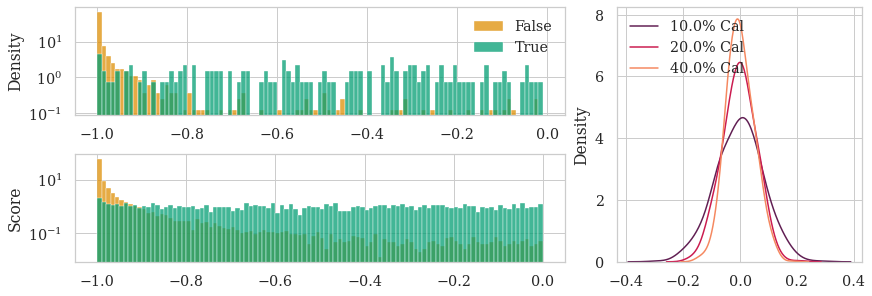

In [5]:
instance = instances[0]
test_idx = instance["test_idx"]
logits = instance["model"].predict(dataset)
base_cp = GraphCP(transformation_sequence=[cp_t.APSTransformation(softmax=True)])
scores = base_cp.get_scores_from_logits(logits)

base_scores = cp_t.APSTransformation(softmax=True).pipe_transform(logits)
raps_scores = cp_t.RegularizerPenalty(k_reg=0, penalty=0.5).pipe_transform(base_scores)
mixing_scores = cp_gt.VertexMPTransformation(neigh_coef=0.6, edge_index=dataset.edge_index, n_vertices=dataset.x.shape[0]).pipe_transform(base_scores)

sns.set_theme(context='notebook', style='whitegrid', palette=sns.color_palette("rocket", 3), font='serif', font_scale=1.3, color_codes=True, rc=None)
gs_kw = dict(width_ratios=[2.0, 1], height_ratios=[1, 1])
fig, axd = plt.subplot_mosaic([['upper right', 'left'],
                               ['lower right', 'left']],
                              gridspec_kw=gs_kw, figsize=(12, 4),
                              layout="constrained")


for multipliers in [1, 2, 4]:
    result = []
    for itr in range(1000):
        calib_idx, eval_idx, calib_mask, eval_mask = dataset_manager.train_test_split(test_idx, F.one_hot(dataset.y[test_idx]).bool(), training_fraction=calib_fraction * multipliers)
        quantile = base_cp.calibrate_from_scores(scores[calib_idx], calib_mask)
        calib_set_size = base_cp.average_set_size(scores[calib_idx] > quantile)
        eval_set_size = base_cp.average_set_size(scores[eval_idx] > quantile)
        set_size_approx = calib_set_size - eval_set_size
        result.append(set_size_approx)
    sns.kdeplot(result, bw_adjust=1.5, ax=axd["left"], label=f"{np.round(calib_fraction * multipliers * 100)}% Cal")
    
axd["left"].legend(loc="upper left")
    
calib_idx, eval_idx, calib_mask, eval_mask = dataset_manager.train_test_split(test_idx, F.one_hot(dataset.y[test_idx]).bool(), training_fraction=0.05)
# f.set_dpi(100)
binwidth=0.01
sns.histplot(base_scores[calib_idx][~calib_mask].cpu().numpy(), color="#DE8F05", binwidth=binwidth, ax=axd["upper right"], label="False", rasterized=True, stat="density")
sns.histplot(base_scores[calib_idx][calib_mask].cpu().numpy(), color="#029E73", binwidth=binwidth, ax=axd["upper right"], label="True", rasterized=True, stat="density")
axd["upper right"].set_yscale("log")

sns.histplot(base_scores[eval_idx][~eval_mask].cpu().numpy(), color="#DE8F05", binwidth=binwidth, ax=axd["lower right"], label="False", rasterized=True, stat="density")
sns.histplot(base_scores[eval_idx][eval_mask].cpu().numpy(), color="#029E73", binwidth=binwidth, ax=axd["lower right"], label="True", rasterized=True, stat="density")
axd["lower right"].set_yscale("log")
axd["lower right"].set_ylabel("Score")

axd["upper right"].legend()


plt.savefig(os.path.join(figures_dir, "estim-set-size.pgf"), format="pgf", bbox_inches='tight')

In [6]:
test_idx = instance["test_idx"]
test_mask = F.one_hot(dataset.y[test_idx]).bool()

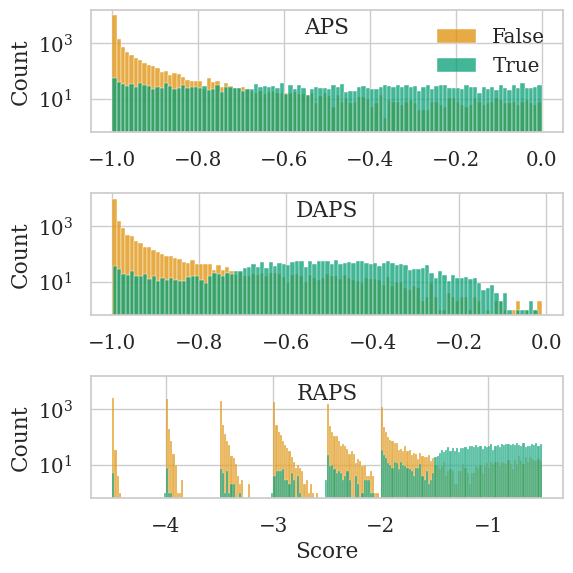

In [7]:
f, axs = plt.subplots(3, 1, figsize=(6, 6), sharey=True)
f.set_dpi(100)
binwidth=0.01
sns.histplot(base_scores[test_idx][~test_mask].cpu().numpy(), color="#DE8F05", binwidth=binwidth, ax=axs[0], label="False", rasterized=True)
sns.histplot(base_scores[test_idx][test_mask].cpu().numpy(), color="#029E73", binwidth=binwidth, ax=axs[0], label="True", rasterized=True)
axs[0].set_yscale("log")

sns.histplot(mixing_scores[test_idx][~test_mask].cpu().numpy(), color="#DE8F05", binwidth=binwidth, ax=axs[1], rasterized=True)
sns.histplot(mixing_scores[test_idx][test_mask].cpu().numpy(), color="#029E73", binwidth=binwidth, ax=axs[1], rasterized=True)
axs[2].set_yscale("log")

sns.histplot(raps_scores[test_idx][~test_mask].cpu().numpy(), color="#DE8F05", binwidth=binwidth * 2, alpha=0.7, ax=axs[2], rasterized=True)
sns.histplot(raps_scores[test_idx][test_mask].cpu().numpy(), color="#029E73", binwidth=binwidth * 2, alpha=0.7, ax=axs[2], rasterized=True)
axs[1].set_yscale("log")

axs[0].legend(loc="upper right")
axs[2].set_xlabel("Score")

axs[0].text(0.5, 0.85, 'APS',
     horizontalalignment='center',
     verticalalignment='center',
     transform = axs[0].transAxes)
axs[1].text(0.5, 0.85, 'DAPS',
     horizontalalignment='center',
     verticalalignment='center',
     transform = axs[1].transAxes)
axs[2].text(0.5, 0.85, 'RAPS',
     horizontalalignment='center',
     verticalalignment='center',
     transform = axs[2].transAxes)


f.tight_layout()
plt.savefig(os.path.join(figures_dir, "score-hists.pgf"), format="pgf", bbox_inches='tight')

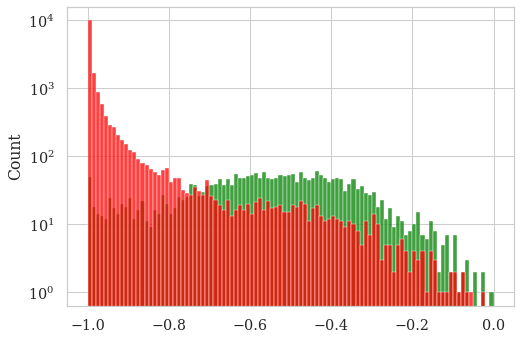

In [98]:

sns.histplot(mixing_scores[test_idx][test_mask].cpu().numpy(), color="green", binwidth=binwidth)
sns.histplot(mixing_scores[test_idx][~test_mask].cpu().numpy(), color="red", binwidth=binwidth)
plt.yscale("log")

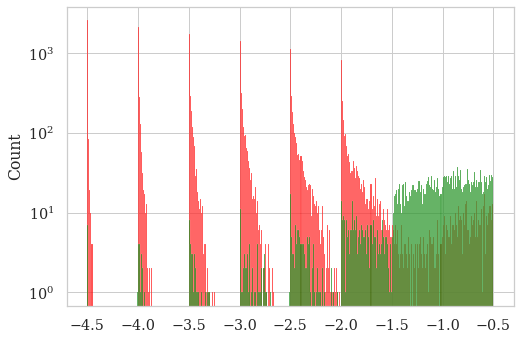

In [101]:
sns.histplot(raps_scores[test_idx][~test_mask].cpu().numpy(), color="red", binwidth=binwidth, alpha=0.7)
sns.histplot(raps_scores[test_idx][test_mask].cpu().numpy(), color="green", binwidth=binwidth, alpha=0.7)

plt.yscale("log")

<AxesSubplot:ylabel='Density'>

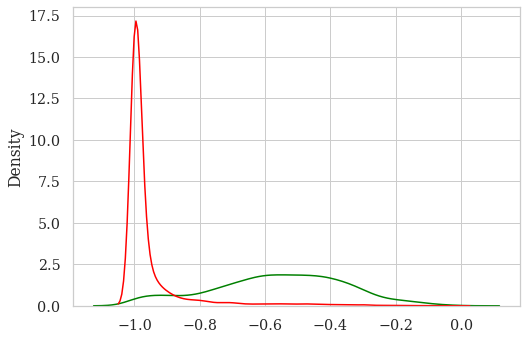

In [67]:
sns.kdeplot(mixing_scores[test_idx][test_mask].cpu().numpy(), color="green")
sns.kdeplot(mixing_scores[test_idx][~test_mask].cpu().numpy(), color="red")

In [5]:
n_elems = 10000
probs = torch.ones(size=(n_elems, 2)) / 2
ys = torch.rand(size=(n_elems, 2)).argmax(dim=1)
y_mask = F.one_hot(ys).bool()

In [6]:
bad_random = torch.rand(size=(n_elems,))
bad_random = torch.stack([bad_random, 1-bad_random]).T

In [7]:
good_estim = 0.3 * probs + 0.7 * bad_random
bad_estim = bad_random

In [8]:
torch.abs(probs - good_estim).sum()

tensor(3505.1736)

In [9]:
torch.abs(probs - bad_estim).sum()

tensor(5007.3906)

In [10]:
baseline_cp = GraphCP(transformation_sequence=[cp_t.APSTransformation(softmax=False)])
baseline_scores = baseline_cp.get_scores_from_logits(probs)
baseline_results = baseline_cp.shuffle_metrics_over_coverage(baseline_scores, y_mask, coverage_values, metrics_dict=metrics_dict)

good_cp = GraphCP(transformation_sequence=[cp_t.APSTransformation(softmax=False)])
good_scores = baseline_cp.get_scores_from_logits(good_estim)
good_results = baseline_cp.shuffle_metrics_over_coverage(good_scores, y_mask, coverage_values, metrics_dict=metrics_dict)

bad_cp = GraphCP(transformation_sequence=[cp_t.APSTransformation(softmax=False)])
bad_scores = baseline_cp.get_scores_from_logits(bad_estim)
bad_results = baseline_cp.shuffle_metrics_over_coverage(bad_scores, y_mask, coverage_values, metrics_dict=metrics_dict)

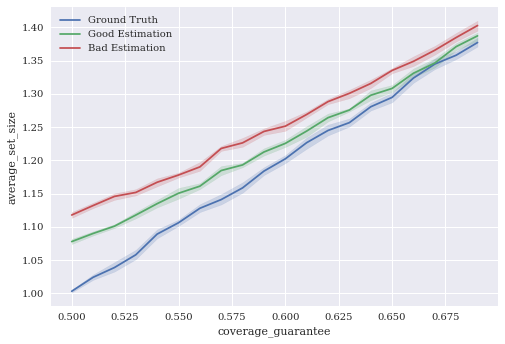

In [11]:
sns.lineplot(data=baseline_results, x="coverage_guarantee", y="average_set_size", label="Ground Truth")
sns.lineplot(data=good_results,  x="coverage_guarantee", y="average_set_size", label="Good Estimation")
sns.lineplot(data=bad_results,  x="coverage_guarantee", y="average_set_size", label="Bad Estimation")
plt.legend()

In [12]:
baseline_cp = GraphCP(transformation_sequence=[cp_t.APSTransformation(softmax=False), cp_t.RegularizerPenalty(k_reg=0, penalty=0.4)])
baseline_scores = baseline_cp.get_scores_from_logits(probs)
baseline_results = baseline_cp.shuffle_metrics_over_coverage(baseline_scores, y_mask, coverage_values, metrics_dict=metrics_dict)

good_cp = GraphCP(transformation_sequence=[cp_t.APSTransformation(softmax=False), cp_t.RegularizerPenalty(k_reg=0, penalty=0.4)])
good_scores = baseline_cp.get_scores_from_logits(good_estim)
good_results = baseline_cp.shuffle_metrics_over_coverage(good_scores, y_mask, coverage_values, metrics_dict=metrics_dict)

bad_cp = GraphCP(transformation_sequence=[cp_t.APSTransformation(softmax=False), cp_t.RegularizerPenalty(k_reg=0, penalty=0.4)])
bad_scores = baseline_cp.get_scores_from_logits(bad_estim)
bad_results = baseline_cp.shuffle_metrics_over_coverage(bad_scores, y_mask, coverage_values, metrics_dict=metrics_dict)

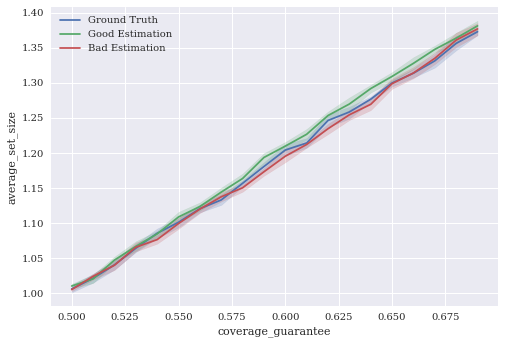

In [13]:
sns.lineplot(data=baseline_results, x="coverage_guarantee", y="average_set_size", label="Ground Truth")
sns.lineplot(data=good_results,  x="coverage_guarantee", y="average_set_size", label="Good Estimation")
sns.lineplot(data=bad_results,  x="coverage_guarantee", y="average_set_size", label="Bad Estimation")
plt.legend()

### Experiments on Synthetic Data

In [9]:
from sklearn.mixture import GaussianMixture
from sklearn.datasets import load_iris

import os

import sklearn
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch_geometric


from gnn_cp.cp.graph_cp import GraphCP
import gnn_cp.cp.transformations as cp_t
import gnn_cp.cp.graph_transformations as cp_gt
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, accuracy_score
from sklearn.datasets import make_blobs

In [10]:
def kl_div(p, q):
    return torch.sum(p * torch.log(p / q), dim=1)

def js_div(p, q):
    m = 0.5 * (p + q)
    return 0.5 * kl_div(p, m) + 0.5 * kl_div(q, m)

# region data generation
class MultivariateGaussianDataGenerator():
    def __init__(self, n_centers, radius, variance):
        self.n_centers = n_centers
        self.radius = radius
        self.variance = variance
        self.centers = [radius * torch.tensor([np.cos(2 * np.pi * i / n_centers), np.sin(2 * np.pi * i / n_centers)]).double() for i in range(n_centers)]
        self.dists = [torch.distributions.MultivariateNormal(center, torch.tensor([[1., 0.], [0., 1.]]).double() * variance) for center in self.centers]


    @staticmethod
    def conditional_probs(X, dists):
        p = torch.stack([dist.log_prob(X).exp() for dist in dists], dim=1)
        p = p / p.sum(dim=1).reshape(-1, 1)
        return p.float()

    @staticmethod
    def sample_labels(p):
        return torch.multinomial(p, 1).reshape(-1)

    def generate_data(self, n_samples):
        samples = [dist.sample((n_samples,)) for dist in self.dists]
        data = torch.cat(samples, dim=0)
        p_true = self.conditional_probs(data, self.dists)
        labels = self.sample_labels(p_true)
        return data, labels, p_true
# endregion

# region data degradation
def prob_normalize(x):
    y = x - x.min(dim=1).values.reshape(-1, 1)
    return y / y.sum(dim=1).reshape(-1, 1)

def degrade_uniform_noise(p, noise_coef=0.1):
    noise = prob_normalize(torch.rand_like(p))
    p = (1 - noise_coef) * p + noise * noise_coef
    return p

def degrade_random_selection(p, selection_prob=0.1, lower_prob_coef=0.1, higher_prob_coef=0.7):
    selection_mask = torch.bernoulli(torch.ones(p.shape[0]) * selection_prob).bool()
    group_1_idx = selection_mask.nonzero().reshape(-1)
    group_2_idx = (~selection_mask).nonzero().reshape(-1)
    
    result = p.clone()
    result[group_1_idx] = degrade_uniform_noise(p[group_1_idx], noise_coef=higher_prob_coef)
    result[group_2_idx] = degrade_uniform_noise(p[group_2_idx], noise_coef=lower_prob_coef)
    return result
    

def degrade_uniform_scaler(p, noise_coef=0.1):
    noise = torch.ones_like(p) / p.shape[1]
    res = (1 - noise_coef) * p + noise * noise_coef
    return res
# endregion

def make_homophily_synthetic_network(probs, density_coef = 0.2, noise_coef = 0.0):
    classes = probs.argmax(dim=1)

    PA = torch.zeros((probs.shape[0], probs.shape[0]))
    for i in range(probs.shape[0]):
        PA[i] = probs[i][classes[torch.arange(probs.shape[0])]]
    noise_PA = (torch.rand_like(PA) - 0.5) * noise_coef
    PA = abs(PA + noise_PA)
    PA[PA > 1] = 1
    PA[PA < 0] = 0
    A = torch.bernoulli(PA * density_coef)
    edge_index = torch_geometric.utils.dense_to_sparse(A)[0]
    return edge_index

def make_dotproduct_synthetic_network(probs, density_coef = 0.2, noise_coef = 0.0):
    classes = probs.argmax(dim=1)

    PA = torch.matmul(probs, probs.T)
    
    noise_PA = (torch.rand_like(PA) - 0.5) * noise_coef
    PA = abs(PA + noise_PA)
    PA[PA > 1] = 1
    PA[PA < 0] = 0
    A = torch.bernoulli(PA * density_coef)
    edge_index = torch_geometric.utils.dense_to_sparse(A)[0]
    return edge_index

def make_knn_synthetic_network(probs, k=15, noise_coef=0.5):
    ref_prob = degrade_uniform_noise(probs, noise_coef=noise_coef)
    edge_index = torch_geometric.nn.pool.knn_graph(ref_prob, k=k)
    return edge_index

def make_delta_synthetic_network(probs, delta, density_prob=0.2):
    result = torch.nn.PairwiseDistance(p=1)(probs[None, :], probs[:, None])
    result = result < delta
    
    return result.nonzero().T

def best_temp_scaling(probs, reference, step_size=0.1):
    temp = 1
    best_temp = 1
    best_res = probs.clone()
    count_down = 10

    while True:
        res = F.softmax(torch.log(probs) * temp, dim=1)
        if js_div(res, reference).mean() < js_div(best_res, reference).mean():
            best_temp = temp
            best_res = res
        else:
            count_down -= 1
            if count_down == 0:
                break
        temp *= (1 + step_size)
    return best_temp, best_res

In [12]:
n_centers = 3
radius = 1.7
variance = 1.2

# synthetic data
data = MultivariateGaussianDataGenerator(n_centers, radius, variance)
X, y, p_true = data.generate_data(1000)

In [13]:
make_delta_synthetic_network(p_true, 0.1)

tensor([[   0,    0,    0,  ..., 2999, 2999, 2999],
        [   0,  181,  264,  ..., 2995, 2998, 2999]])

Text(0.5, 1.0, 'Noisy Conditional Probability')

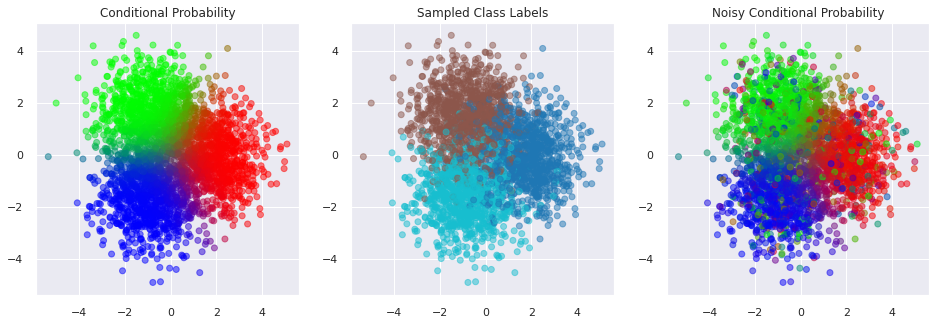

In [14]:
p_noisy = degrade_random_selection(p_true, selection_prob=0.2, lower_prob_coef=0.1, higher_prob_coef=1)

sns.set()
fig, ax = plt.subplots(1, 3, figsize=(16, 5))
ax[0].scatter(X[:, 0], X[:, 1], c=p_true, alpha=0.5, cmap="colorblind")
ax[1].scatter(X[:, 0], X[:, 1], c=y, cmap="tab10", alpha=0.5)
ax[2].scatter(X[:, 0], X[:, 1], c=p_noisy, alpha=0.5)
ax[0].set_title("Conditional Probability")
ax[1].set_title("Sampled Class Labels")
ax[2].set_title("Noisy Conditional Probability")

In [15]:
p_s_noise_range = np.arange(0, 1, 0.05).round(3)
p_selection_range = np.arange(0, 1, 0.05).round(3)

result = []
for p_selection in p_selection_range:
    for p_s in p_s_noise_range:
        p_noisy = degrade_random_selection(p_true, selection_prob=p_selection, lower_prob_coef=0.1, higher_prob_coef=p_s)

        acc = accuracy_score(y_pred=p_noisy.argmax(dim=1).numpy(), y_true=y.numpy())
        js_div_result = js_div(p_noisy, p_true).mean().item()
        result.append({
            "p_select": p_selection,
            "noise_coef": p_s,
            "accuracy": acc,
            "js_div": js_div_result
        })

result = pd.DataFrame(result)

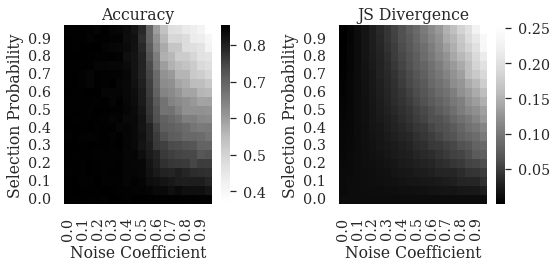

In [16]:
p_noisy_ref = degrade_random_selection(p_true, selection_prob=0.2, lower_prob_coef=0.1, higher_prob_coef=0.7)
sns.set_theme(context='notebook', style='whitegrid', palette='colorblind', font='serif', font_scale=1.3, color_codes=True, rc=None)
f, axs = plt.subplots(1, 2, figsize=(8, 4))

# axs[0].scatter(X[:, 0], X[:, 1], c=p_noisy_ref, alpha=0.6)
# axs[0].set_title("Noisy Conditional Probability")

sns.heatmap(result.pivot("p_select", "noise_coef")["accuracy"], cmap=sns.color_palette("Greys", as_cmap=True), ax=axs[0])
axs[0].set_xlabel("Noise Coefficient")
axs[0].set_ylabel("Selection Probability")
axs[0].set_title("Accuracy")

sns.heatmap(result.pivot("p_select", "noise_coef")["js_div"], cmap=sns.color_palette("Greys", as_cmap=True).reversed(), ax=axs[1])
axs[1].set_xlabel("Noise Coefficient")
axs[1].set_ylabel("Selection Probability")
axs[1].set_title("JS Divergence")
plt.tight_layout()
axs[0].invert_yaxis()
axs[1].invert_yaxis()

plt.savefig(os.path.join(figures_dir, "synthetic_data_noise_impact.pgf"), format="pgf", bbox_inches='tight')

Text(0.5, 0.98, 'Mixing probabilites over kNN graph')

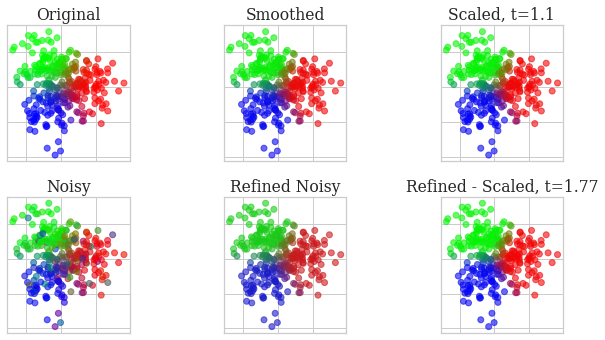

In [72]:
k = 45

edge_index = make_delta_synthetic_network(p_true, delta=0.4)

p_smoothed = cp_gt.VertexMPTransformation(neigh_coef=1, edge_index=edge_index, n_vertices=p_true.shape[0]).pipe_transform(p_true.to(device))
smooth_temp, p_smooth_scaled = best_temp_scaling(p_smoothed.cpu(), p_true.cpu())

p_noisy = degrade_random_selection(p_true, selection_prob=0.2, lower_prob_coef=0.1, higher_prob_coef=0.7)
p_refined = cp_gt.VertexMPTransformation(neigh_coef=1, edge_index=edge_index, n_vertices=p_true.shape[0]).pipe_transform(p_noisy.to(device))
refined_temp, p_refined_scaled = best_temp_scaling(p_refined.cpu(), p_true.cpu())

ploting_idx = torch.randperm(p_smoothed.shape[0])[:300]

sns.set_theme(context='notebook', style='whitegrid', palette='colorblind', font='serif', font_scale=1.3, color_codes=True, rc=None)
fig, ax = plt.subplots(2, 3, figsize=(10, 5), tight_layout=True)
ax[0, 0].scatter(X[ploting_idx, 0], X[ploting_idx, 1], c=p_true.cpu()[ploting_idx], alpha=0.6)
ax[0, 1].scatter(X[ploting_idx, 0], X[ploting_idx, 1], c=p_smoothed.cpu()[ploting_idx], alpha=0.6)
ax[1, 0].scatter(X[ploting_idx, 0], X[ploting_idx, 1], c=p_noisy.cpu()[ploting_idx], alpha=0.6)
ax[1, 1].scatter(X[ploting_idx, 0], X[ploting_idx, 1], c=p_refined.cpu()[ploting_idx], alpha=0.6)
ax[0, 2].scatter(X[ploting_idx, 0], X[ploting_idx, 1], c=p_smooth_scaled.cpu()[ploting_idx], alpha=0.6)
ax[1, 2].scatter(X[ploting_idx, 0], X[ploting_idx, 1], c=p_refined_scaled.cpu()[ploting_idx], alpha=0.6)

ax[0, 0].set_title("Original")
ax[0, 1].set_title("Smoothed")
ax[1, 0].set_title("Noisy")
ax[1, 1].set_title("Refined Noisy")
ax[0, 2].set_title(f"Scaled, t={round(smooth_temp, 2)}")
ax[1, 2].set_title(f"Refined - Scaled, t={round(refined_temp, 2)}")
for i in range(2):
    for j in range(3):
        ax[i, j].set_xticklabels([])
        ax[i, j].set_yticklabels([])
        ax[i, j].set_aspect('equal')

f.subplots_adjust(wspace=0, hspace=0)

f.suptitle(f"Mixing probabilites over kNN graph")
# plt.savefig(os.path.join(figures_dir, "knn_synthetic_refinement.png"), dpi=300, bbox_inches='tight')
# plt.savefig(os.path.join(figures_dir, "knn_synthetic_refinement.pgf"), format="pgf", bbox_inches='tight')

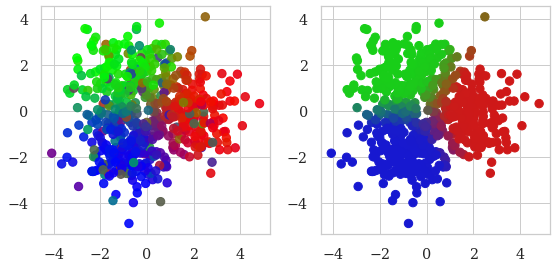

In [17]:
k = 45

# edge_index = make_knn_synthetic_network(p_true, k=k, noise_coef=0.1)
edge_index = make_delta_synthetic_network(p_true, delta=0.4)

p_smoothed = cp_gt.VertexMPTransformation(neigh_coef=1, edge_index=edge_index, n_vertices=p_true.shape[0]).pipe_transform(p_true.to(device))
smooth_temp, p_smooth_scaled = best_temp_scaling(p_smoothed.cpu(), p_true.cpu())

p_noisy = degrade_random_selection(p_true, selection_prob=0.2, lower_prob_coef=0.1, higher_prob_coef=0.7)
p_refined = cp_gt.VertexMPTransformation(neigh_coef=1, edge_index=edge_index, n_vertices=p_true.shape[0]).pipe_transform(p_noisy.to(device))
refined_temp, p_refined_scaled = best_temp_scaling(p_refined.cpu(), p_true.cpu())

ploting_idx = torch.randperm(p_smoothed.shape[0])[:600]

sns.set_theme(context='notebook', style='whitegrid', palette='colorblind', font='serif', font_scale=1.3, color_codes=True, rc=None)
fig, ax = plt.subplots(1, 2, figsize=(8, 4), tight_layout=True)
# ax[0, 0].scatter(X[ploting_idx, 0], X[ploting_idx, 1], c=p_true.cpu()[ploting_idx], alpha=0.6)
# ax[0, 1].scatter(X[ploting_idx, 0], X[ploting_idx, 1], c=p_smoothed.cpu()[ploting_idx], alpha=0.6)
ax[0].scatter(X[ploting_idx, 0], X[ploting_idx, 1], c=p_noisy.cpu()[ploting_idx], alpha=0.9, s=70, cmap="tab10")
ax[1].scatter(X[ploting_idx, 0], X[ploting_idx, 1], c=p_refined.cpu()[ploting_idx], alpha=1,  s=70, cmap="tab10")
# ax[0, 2].scatter(X[ploting_idx, 0], X[ploting_idx, 1], c=p_smooth_scaled.cpu()[ploting_idx], alpha=0.6)
# ax[1, 2].scatter(X[ploting_idx, 0], X[ploting_idx, 1], c=p_refined_scaled.cpu()[ploting_idx], alpha=0.6)

# ax[0, 0].set_title("Original")
# ax[0, 1].set_title("Smoothed")
# ax[0].set_title("Noisy")
# ax[1].set_title("Defused Noisy")
# ax[0, 2].set_title(f"Scaled, t={round(smooth_temp, 2)}")
# ax[1, 2].set_title(f"Refined - Scaled, t={round(refined_temp, 2)}")
# for i in range(2):
    # for j in range(3):
        # ax[i, j].set_xticklabels([])
        # ax[i, j].set_yticklabels([])
        # ax[i, j].set_aspect('equal')

# f.subplots_adjust(wspace=0, hspace=0)

# f.suptitle(f"Mixing probabilites over kNN graph")
# plt.savefig(os.path.join(figures_dir, "knn_synthetic_refinement.png"), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(figures_dir, "knn_synthetic_refinement.pgf"), format="pgf", bbox_inches='tight')

In [21]:
dist_0 = torch.distributions.MultivariateNormal(torch.tensor([1., 1.]), torch.tensor([[1., 0.], [0., 1.]]) * 0.5)
dist_1 = torch.distributions.MultivariateNormal(torch.tensor([-1., -1.]), torch.tensor([[1., 0.], [0., 1.]]) * 0.5)

samples_0 = dist_0.sample((1000,))
samples_1 = dist_1.sample((1000,))
data = torch.cat([samples_0, samples_1], dim=0)
labels = torch.cat([torch.zeros(1000), torch.ones(1000)], dim=0).long()

val_samples_0 = dist_0.sample((100,))
val_samples_1 = dist_1.sample((100,))
val_data = torch.cat([val_samples_0, val_samples_1], dim=0)
val_labels = torch.cat([torch.zeros(100), torch.ones(100)], dim=0).long()

test_samples_0 = dist_0.sample((100,))
test_samples_1 = dist_1.sample((100,))
test_data = torch.cat([test_samples_0, test_samples_1], dim=0)
test_labels = torch.cat([torch.zeros(100), torch.ones(100)], dim=0).long()

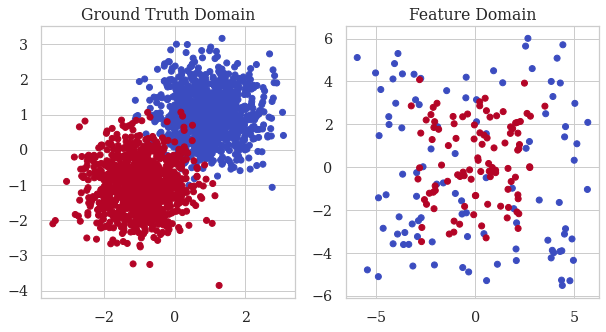

In [22]:
class CircularKernel(nn.Module):
    def __init__(self):
        super().__init__()
        self.mins = torch.tensor([0., 0.])

    def fit(self, X):
        self.mins = X.min(axis=0)[0]
    
    def predict(self, X):
        ref = X - self.mins
        res = torch.hstack([(ref[:, 0] * torch.sin(torch.rand(ref.shape[0]) * 2 * np.pi)).reshape(-1, 1), (ref[:, 1] * torch.sin(torch.rand(ref.shape[0]) * 2 * np.pi)).reshape(-1, 1)])
        return res


# def circular_kernel(X):
#     ref = X - X.min(axis=0)[0]
#     res = torch.hstack([(ref[:, 0] * torch.sin(torch.rand(ref.shape[0]) * 2 * np.pi)).reshape(-1, 1), (ref[:, 1] * torch.sin(torch.rand(ref.shape[0]) * 2 * np.pi)).reshape(-1, 1)])
#     return res

transform = CircularKernel()
transform.fit(data)
train_transformed = transform.predict(data)
val_transformed = transform.predict(val_data)
test_transformed = transform.predict(test_data)

# test_transformed = circular_kernel(test_data)
# train_transformed = circular_kernel(data)

sns.set_theme(context='notebook', style='whitegrid', palette='colorblind', font='serif', font_scale=1.3, color_codes=True, rc=None)
f, axs = plt.subplots(1, 2, figsize=(10, 5))
plt.set_cmap('coolwarm')
axs[0].scatter(data[:, 0], data[:, 1], c=labels)
axs[0].set_title('Ground Truth Domain')

axs[1].scatter(test_transformed[:, 0], test_transformed[:, 1], c=test_labels)
axs[1].set_title('Feature Domain')

plt.savefig(os.path.join(figures_dir, "synthetic-model-experiment.pgf"), format="pgf", bbox_inches='tight')

plt.show()

In [23]:
n_hidden = 20
n_layers = 2
class MLPModule(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.fc1 = nn.Linear(2, n_hidden)
        self.fc2 = nn.ModuleList([nn.Linear(n_hidden, n_hidden) for _ in range(n_layers - 1)])
        self.fc3 = nn.Linear(n_hidden, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        for layer in self.fc2:
            x = F.relu(layer(x))
        # x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
model = MLPModule()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

def train_epoch(X, y):
    model.train()
    optimizer.zero_grad()
    output = model(X)
    loss = criterion(output, y)
    loss.backward()
    optimizer.step()
    return loss.item()

def eval_epoch(X, y):
    model.eval()
    output = model(X)
    loss = criterion(output, y)
    return loss.item()

for epoch in range(100):
    train_loss = train_epoch(train_transformed, labels)
    eval_loss = eval_epoch(val_transformed, val_labels)
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, Train Loss: {train_loss}, Eval Loss: {eval_loss}")

model.eval()
with torch.no_grad():
    test_pred = model(test_transformed)

test_softmaxes = F.softmax(test_pred, dim=1)
print(classification_report(y_pred=test_pred.argmax(dim=1).numpy(), y_true=test_labels.numpy()))

Epoch: 0, Train Loss: 0.7336373925209045, Eval Loss: 0.7104974389076233
Epoch: 10, Train Loss: 0.6069258451461792, Eval Loss: 0.5994804501533508
Epoch: 20, Train Loss: 0.4789135754108429, Eval Loss: 0.49316105246543884
Epoch: 30, Train Loss: 0.45285123586654663, Eval Loss: 0.48600634932518005
Epoch: 40, Train Loss: 0.43595656752586365, Eval Loss: 0.45792603492736816
Epoch: 50, Train Loss: 0.42957332730293274, Eval Loss: 0.4512123465538025
Epoch: 60, Train Loss: 0.4251982867717743, Eval Loss: 0.44791820645332336
Epoch: 70, Train Loss: 0.4228591322898865, Eval Loss: 0.44473811984062195
Epoch: 80, Train Loss: 0.42138153314590454, Eval Loss: 0.4442845284938812
Epoch: 90, Train Loss: 0.42020443081855774, Eval Loss: 0.44573983550071716
              precision    recall  f1-score   support

           0       0.94      0.72      0.81       100
           1       0.77      0.95      0.85       100

    accuracy                           0.83       200
   macro avg       0.85      0.83      0.8

In [24]:
def conditional_probs(X, dist_0, dist_1):
    p_0 = dist_0.log_prob(X).exp()
    p_1 = dist_1.log_prob(X).exp()
    
    return torch.hstack([(p_0 / (p_0 + p_1)).reshape(-1, 1), (p_1 / (p_0 + p_1)).reshape(-1, 1)])

def return_prob_logits(X, dist_0, dist_1):
    p_0 = dist_0.log_prob(X)
    p_1 = dist_1.log_prob(X)
    
    return torch.hstack([p_0.reshape(-1, 1), p_1.reshape(-1, 1)])


              precision    recall  f1-score   support

           0       0.99      0.96      0.97       100
           1       0.96      0.99      0.98       100

    accuracy                           0.97       200
   macro avg       0.98      0.97      0.97       200
weighted avg       0.98      0.97      0.97       200



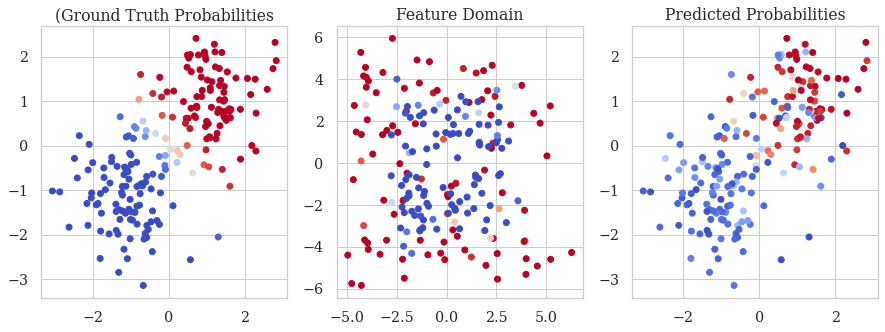

In [25]:
r = conditional_probs(test_data, dist_0, dist_1)
print(classification_report(y_pred=r.argmax(dim=1).numpy(), y_true=test_labels.numpy()))

f, ax = plt.subplots(1, 3, figsize=(15, 5))
feature_data = transform.predict(test_data)
ax[0].scatter(test_data[:, 0], test_data[:, 1], c=r[:, 0])
ax[0].set_title('(Ground Truth Probabilities')
ax[1].scatter(feature_data[:, 0], feature_data[:, 1], c=r[:, 0])
ax[1].set_title('Feature Domain')
ax[2].scatter(test_data[:, 0], test_data[:, 1], c=test_softmaxes[:, 0])
ax[2].set_title('Predicted Probabilities')

plt.savefig(os.path.join(figures_dir, "synthetic-model-experiment.pgf"), format="pgf", bbox_inches='tight')


In [26]:
calib_fraction = 0.5

lambda_vals = np.arange(0, 1.51, 0.05).round(3)
fixed_neigh_coef = 0.55
coverage_values = np.arange(0.5, 0.99, 0.05).round(3)


def singleton_hit(pred_set, true_mask):
    one_sized_pred = (pred_set.sum(axis=1) == 1)
    result = pred_set[true_mask][one_sized_pred].sum().item() / pred_set.shape[0]
    return result

singleton_hit_metric = lambda pred_set, true_mask: singleton_hit(pred_set, true_mask)
set_size_metric = lambda pred_set, true_mask: GraphCP.average_set_size(pred_set)
coverage_metric = lambda pred_set, true_mask: GraphCP.coverage(pred_set, true_mask)
argmax_accuracy = lambda pred_set, true_mask: GraphCP.argmax_accuracy(pred_set, true_mask)

metrics_dict = {
    "empi_coverage": coverage_metric,
    "average_set_size": set_size_metric,
    "singleton_hit": singleton_hit_metric,
}

In [27]:
result = []
true_mask = F.one_hot(y).bool()

for higher_noise_c in np.arange(0.0, 1.0, 0.05).round(3):
    p_noisy = degrade_random_selection(p_true, selection_prob=0.2, lower_prob_coef=0.1, higher_prob_coef=higher_noise_c)
    cp = GraphCP(transformation_sequence=[cp_t.APSTransformation(softmax=False)])
    p_scores = cp.get_scores_from_logits(p_noisy)
    p_results = cp.shuffle_metrics_over_coverage(p_scores, true_mask, coverage_values, metrics_dict=metrics_dict)
    p_results["noise_coef"] = higher_noise_c
    result.append(p_results)
result = pd.concat(result).reset_index().drop(columns=["index"])

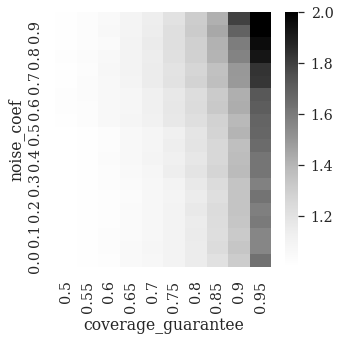

In [28]:
f, ax = plt.subplots(1, 1, figsize=(5, 5), tight_layout=True)

result = result.groupby(["coverage_guarantee", "noise_coef"]).mean().reset_index()
sns.heatmap(result.pivot(index="noise_coef", columns="coverage_guarantee", values="average_set_size"), cmap="Greys", vmax=2)
ax.invert_yaxis()

plt.savefig(os.path.join(figures_dir, "synthetic-error-set-effect.pgf"), format="pgf", bbox_inches='tight')